In [18]:
from hamilton import driver
%reload_ext hamilton.plugins.jupyter_magic

In [20]:
%%testing
def joke_prompt__default(topic: str) -> str:
    data = f"Tell me a short joke about {topic}"
    print(locals())
    return data

{'data'}

In [2]:
%%set_driver
dr = (
    driver.Builder()
    .with_config({"knock": "false"})
    .with_adapters()
    .build()
)

In [3]:
%%set_inputs
topic = "Bingo"

In [4]:
%%set_overrides
""""""

In [5]:
%%set_final_vars --all
final_vars = [
    "joke_messages",
]

In [6]:
%%set_display_config
orient="TB"

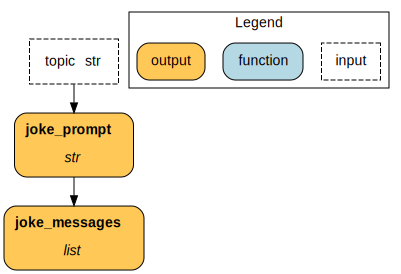

In [7]:
%%cell_to_module -xwm joke
from hamilton.function_modifiers import config

@config.when_not(knock="true")
def joke_prompt__default(topic: str) -> str:
    return f"Tell me a short joke about {topic}"


@config.when(knock="true")
def joke_prompt__knock(topic: str) -> str:
    return f"Knock, knock, knock"


def joke_messages(joke_prompt: str) -> list[dict]:
    return [{"role": "user", "content": joke_prompt}]